## 1. Installation and Setup

In [17]:
# Install required packages
!pip install -q transformers torch gradio sentencepiece requests pandas matplotlib seaborn evaluate bert-score

print("✓ All packages installed successfully!")

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


✓ All packages installed successfully!


## 2. Import Libraries

In [18]:
import requests
import torch
import gradio as gr
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import re
import numpy as np
from transformers import AutoTokenizer, AutoModelForSeq2SeqLM, pipeline
import evaluate
from bert_score import score as bert_score
import warnings
warnings.filterwarnings('ignore')

# Set visualization style
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (14, 6)

# Device setup
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"✓ Using {'GPU: ' + torch.cuda.get_device_name(0) if device == 'cuda' else 'CPU'}")

✓ Using CPU


## 3. Load Pre-trained Models

We'll compare three popular summarization models:
- **T5-small**: Google's Text-to-Text Transfer Transformer
- **BART-base**: Facebook's Bidirectional and Auto-Regressive Transformer
- **PEGASUS-XSum**: Google's model fine-tuned on extreme summarization

In [19]:
print("Loading pre-trained models...\n")

# T5-small
print("1. Loading T5-small...")
t5_tokenizer = AutoTokenizer.from_pretrained("t5-small")
t5_model = AutoModelForSeq2SeqLM.from_pretrained("t5-small").to(device)
t5_model.eval()
print("   ✓ T5-small loaded")

# BART-base
print("\n2. Loading BART-base...")
bart_tokenizer = AutoTokenizer.from_pretrained("facebook/bart-base")
bart_model = AutoModelForSeq2SeqLM.from_pretrained("facebook/bart-base").to(device)
bart_model.eval()
print("   ✓ BART-base loaded")

# PEGASUS
print("\n3. Loading PEGASUS-XSum...")
pegasus_tokenizer = AutoTokenizer.from_pretrained("google/pegasus-xsum")
pegasus_model = AutoModelForSeq2SeqLM.from_pretrained("google/pegasus-xsum").to(device)
pegasus_model.eval()
print("   ✓ PEGASUS-XSum loaded")

# Emotion classifier
print("\n4. Loading emotion classifier...")
emotion_classifier = pipeline(
    "text-classification",
    model="j-hartmann/emotion-english-distilroberta-base",
    top_k=None,
    device=0 if device == "cuda" else -1,
    truncation=True
)
print("   ✓ Emotion classifier loaded")

print("\n✓ All models ready!")

Loading pre-trained models...

1. Loading T5-small...
   ✓ T5-small loaded

2. Loading BART-base...
   ✓ BART-base loaded

3. Loading PEGASUS-XSum...


Some weights of PegasusForConditionalGeneration were not initialized from the model checkpoint at google/pegasus-xsum and are newly initialized: ['model.decoder.embed_positions.weight', 'model.encoder.embed_positions.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


   ✓ PEGASUS-XSum loaded

4. Loading emotion classifier...


Device set to use cpu


   ✓ Emotion classifier loaded

✓ All models ready!


## 4. Surah Names and Data Loading

In [20]:
# Complete list of 114 Surah names
SURAH_NAMES = [
    "Al-Fatihah", "Al-Baqarah", "Ali 'Imran", "An-Nisa", "Al-Ma'idah",
    "Al-An'am", "Al-A'raf", "Al-Anfal", "At-Tawbah", "Yunus",
    "Hud", "Yusuf", "Ar-Ra'd", "Ibrahim", "Al-Hijr",
    "An-Nahl", "Al-Isra", "Al-Kahf", "Maryam", "Ta-Ha",
    "Al-Anbya", "Al-Hajj", "Al-Mu'minun", "An-Nur", "Al-Furqan",
    "Ash-Shu'ara", "An-Naml", "Al-Qasas", "Al-'Ankabut", "Ar-Rum",
    "Luqman", "As-Sajdah", "Al-Ahzab", "Saba", "Fatir",
    "Ya-Sin", "As-Saffat", "Sad", "Az-Zumar", "Ghafir",
    "Fussilat", "Ash-Shuraa", "Az-Zukhruf", "Ad-Dukhan", "Al-Jathiyah",
    "Al-Ahqaf", "Muhammad", "Al-Fath", "Al-Hujurat", "Qaf",
    "Adh-Dhariyat", "At-Tur", "An-Najm", "Al-Qamar", "Ar-Rahman",
    "Al-Waqi'ah", "Al-Hadid", "Al-Mujadila", "Al-Hashr", "Al-Mumtahanah",
    "As-Saf", "Al-Jumu'ah", "Al-Munafiqun", "At-Taghabun", "At-Talaq",
    "At-Tahrim", "Al-Mulk", "Al-Qalam", "Al-Haqqah", "Al-Ma'arij",
    "Nuh", "Al-Jinn", "Al-Muzzammil", "Al-Muddaththir", "Al-Qiyamah",
    "Al-Insan", "Al-Mursalat", "An-Naba", "An-Nazi'at", "'Abasa",
    "At-Takwir", "Al-Infitar", "Al-Mutaffifin", "Al-Inshiqaq", "Al-Buruj",
    "At-Tariq", "Al-A'la", "Al-Ghashiyah", "Al-Fajr", "Al-Balad",
    "Ash-Shams", "Al-Layl", "Ad-Duhaa", "Ash-Sharh", "At-Tin",
    "Al-'Alaq", "Al-Qadr", "Al-Bayyinah", "Az-Zalzalah", "Al-'Adiyat",
    "Al-Qari'ah", "At-Takathur", "Al-'Asr", "Al-Humazah", "Al-Fil",
    "Quraysh", "Al-Ma'un", "Al-Kawthar", "Al-Kafirun", "An-Nasr",
    "Al-Masad", "Al-Ikhlas", "Al-Falaq", "An-Nas"
]

surah_name_to_number = {name: idx + 1 for idx, name in enumerate(SURAH_NAMES)}
print(f"✓ Loaded {len(SURAH_NAMES)} Surah names")

✓ Loaded 114 Surah names


## 5. Data Loading Functions

In [21]:
# Cache for API responses
translations_cache = {}

def clean_html_tags(text):
    """Remove HTML tags from text."""
    text = re.sub(r'<[^>]+>', '', text)
    text = re.sub(r'\s+', ' ', text)
    return text.strip()

def load_surah_translations(surah_number, max_length=4000):
    """Load multiple English translations for a Surah."""
    if surah_number in translations_cache:
        return translations_cache[surah_number]
    
    translation_ids = {
        "Saheeh International": 20,
        "Yusuf Ali": 22,
        "Pickthall": 19,
        "Dr. Ghali": 17,
        "Shakir": 21,
        "Dr. Mustafa Khattab": 131
    }
    
    translations = {}
    
    for name, trans_id in translation_ids.items():
        try:
            url = f"https://api.quran.com/api/v4/quran/translations/{trans_id}?chapter_number={surah_number}"
            response = requests.get(url, timeout=10)
            
            if response.status_code == 200:
                data = response.json()
                verses = data.get('translations', [])
                full_text = ' '.join([clean_html_tags(verse.get('text', '')).strip() 
                                     for verse in verses if verse.get('text')])
                
                if len(full_text) > max_length:
                    full_text = full_text[:max_length]
                    last_period = full_text.rfind('.')
                    if last_period > max_length * 0.8:
                        full_text = full_text[:last_period + 1]
                
                if full_text:
                    translations[name] = full_text
        except Exception as e:
            continue
    
    if translations:
        translations_cache[surah_number] = translations
    
    return translations

print("✓ Data loading functions ready")

✓ Data loading functions ready


## 6. Emotion Detection

In [22]:
def detect_emotions_from_translations(translations_dict, top_n=2):
    """Detect dominant emotions across translations."""
    from collections import Counter
    emotion_scores = Counter()
    
    for translation_name, text in translations_dict.items():
        sentences = re.split(r'[.!?]+', text)
        
        for sentence in sentences:
            sentence = sentence.strip()
            if len(sentence) < 15:
                continue
            
            if len(sentence) > 512:
                sentence = sentence[:512]
                
            try:
                results = emotion_classifier(sentence, truncation=True, max_length=512)
                if results and len(results) > 0:
                    for emotion_data in results[0]:
                        emotion = emotion_data['label']
                        score = emotion_data['score']
                        emotion_scores[emotion] += score
            except:
                continue
    
    if not emotion_scores:
        return ["neutral"]
    
    top_emotions = [emotion for emotion, score in emotion_scores.most_common(top_n)]
    
    # Map to spiritual context
    emotion_mapping = {
        'joy': 'hope and joy',
        'fear': 'reverence and caution',
        'sadness': 'reflection and solemnity',
        'anger': 'warning and admonition',
        'surprise': 'wonder and awe',
        'disgust': 'disapproval',
        'neutral': 'contemplation'
    }
    
    return [emotion_mapping.get(e, e) for e in top_emotions]

print("✓ Emotion detection ready")

✓ Emotion detection ready


## 7. Summarization Functions

In [23]:
# Load ROUGE metric
rouge_metric = evaluate.load("rouge")

def generate_summary_t5(text, max_length=150):
    """Generate summary with T5."""
    input_text = f"summarize: {text}"
    inputs = t5_tokenizer(input_text, max_length=512, truncation=True, return_tensors="pt").to(device)
    
    with torch.no_grad():
        outputs = t5_model.generate(
            **inputs,
            max_length=max_length,
            min_length=40,
            num_beams=4,
            length_penalty=2.0,
            early_stopping=True
        )
    
    return t5_tokenizer.decode(outputs[0], skip_special_tokens=True)

def generate_summary_bart(text, max_length=150):
    """Generate summary with BART."""
    inputs = bart_tokenizer(text, max_length=512, truncation=True, return_tensors="pt").to(device)
    
    with torch.no_grad():
        outputs = bart_model.generate(
            **inputs,
            max_length=max_length,
            min_length=40,
            num_beams=4,
            length_penalty=2.0,
            early_stopping=True
        )
    
    return bart_tokenizer.decode(outputs[0], skip_special_tokens=True)

def generate_summary_pegasus(text, max_length=150):
    """Generate summary with PEGASUS."""
    inputs = pegasus_tokenizer(text, max_length=512, truncation=True, return_tensors="pt").to(device)
    
    with torch.no_grad():
        outputs = pegasus_model.generate(
            **inputs,
            max_length=max_length,
            min_length=40,
            num_beams=4,
            length_penalty=2.0,
            early_stopping=True
        )
    
    return pegasus_tokenizer.decode(outputs[0], skip_special_tokens=True)

print("✓ Summarization functions ready")

✓ Summarization functions ready


## 8. Test Dataset

Reference summaries for evaluation

In [32]:
test_samples = [
    {
        "surah_number": 1,
        "surah_name": "Al-Fatihah",
        "summary": (
            "Al-Fatihah, the opening chapter of the Quran, serves as a comprehensive introduction to its core themes. "
            "It praises Allah as the Lord of all worlds, the Most Gracious, the Most Merciful, and the Master of the Day of Judgment. "
            "The Surah establishes the relationship between the servant and the Creator by affirming exclusive worship and total reliance on Allah alone. "
            "It concludes with a supplication for guidance to the straight path—the path of those blessed by Allah—and protection from the paths of those who go astray."
        ),
    },
    {
        "surah_number": 18,
        "surah_name": "Al-Kahf",
        "summary": (
            "Surah Al-Kahf presents four major narratives, each illustrating a distinct type of trial believers may face in life. "
            "It begins with the story of the People of the Cave, young believers who fled persecution and were preserved by Allah for many years, "
            "symbolizing the trial of faith. The parable of the man with two gardens teaches the trial of wealth and the dangers of arrogance. "
            "The journey of Moses with Khidr demonstrates the trial of knowledge and the importance of divine wisdom beyond human understanding. "
            "Finally, the account of Dhul-Qarnayn shows the trial of power and just leadership. The chapter emphasizes humility, reliance on Allah, "
            "the reality of the Hereafter, and the transient nature of worldly life."
        ),
    },
    {
        "surah_number": 2,
        "surah_name": "Al-Baqarah",
        "summary": (
            "Surah Al-Baqarah is the longest Surah in the Quran and provides extensive guidance on spiritual, social, legal, and moral matters. "
            "It begins by describing the characteristics of believers, disbelievers, and hypocrites, setting the foundation for understanding human behavior. "
            "The Surah recounts stories of previous nations—most notably the Children of Israel—and highlights their repeated struggles with obedience, "
            "serving as lessons for the Muslim community. It introduces foundational legal rulings regarding marriage, divorce, inheritance, fasting, charity, "
            "punishment, financial conduct, and the ethics of warfare. The Surah also discusses the change of the Qiblah from Jerusalem to Makkah, "
            "affirming the importance of submission to Allah's command. Throughout, it emphasizes faith, steadfastness, gratitude, patience, "
            "and the importance of seeking Allah’s guidance in all matters."
        ),
    },
    {
        "surah_number": 56,
        "surah_name": "Al-Waqi'ah",
        "summary": (
            "Surah Al-Waqi'ah focuses on the events of the Day of Resurrection and categorizes humanity into three distinct groups. "
            "The foremost (As-Sabiqun) are those who excelled in righteousness and receive the highest ranks and unparalleled rewards in Paradise. "
            "The companions of the right (Ashab al-Yamin) enjoy bliss and comfort in the gardens of Paradise, while the companions of the left "
            "(Ashab al-Shimal) face torment for their rejection of truth. The Surah emphasizes Allah’s absolute creative power, the signs of divine "
            "design in nature, and the certainty of resurrection. It refutes doubts about life after death and warns against arrogance, urging people "
            "to reflect on their origins and their ultimate return to their Creator."
        ),
    },
    {
        "surah_number": 67,
        "surah_name": "Al-Mulk",
        "summary": (
            "Surah Al-Mulk affirms Allah's complete sovereignty over the heavens and the earth, reminding humanity that creation has purpose and precision. "
            "It begins by declaring the perfection of Allah’s dominion and the deliberate nature of life and death as a test to reveal who is best in deeds. "
            "The Surah invites people to reflect upon the skies, the stars, the earth, and the natural world as signs of divine craftsmanship. "
            "It warns those who deny resurrection and reject the message of the Prophets, describing the consequences awaiting them in the Hereafter. "
            "At the same time, it gives hope to believers who fear their Lord unseen and strive to follow His guidance. The chapter instills humility, "
            "awareness of the Hereafter, and recognition of Allah’s sustaining power over all creation."
        ),
    },
    {
        "surah_number": 114,
        "surah_name": "An-Nas",
        "summary": (
            "Surah An-Nas is a powerful supplication for protection, teaching believers to seek refuge in Allah—Lord, King, and God of humanity. "
            "It specifically asks for protection from the hidden whispers of Shaytan, who subtly influences thoughts and hearts. "
            "The Surah highlights the vulnerability of human beings to spiritual harm and the constant need for divine protection. "
            "It emphasizes that these whispers can come from both jinn and humans, reminding believers to remain vigilant and anchored in remembrance of Allah."
        ),
    },
    {
        "surah_number": 103,
        "surah_name": "Al-'Asr",
        "summary": (
            "Surah Al-'Asr is a concise yet profound summary of the path to success. It opens by swearing an oath on time, declaring that humanity in general is in a state of loss. "
            "The exception is for those who fulfill four essential qualities: sincere faith in Allah, consistent righteous actions, encouraging and upholding truth, "
            "and encouraging patience and perseverance. The Surah captures the essence of Islamic teachings in a few verses, emphasizing accountability, "
            "the importance of purposeful living, and the communal responsibility of supporting one another in faith and resilience."
        ),
    },
]

print(f"✓ Created test dataset with {len(test_samples)} examples")


print(f"✓ Created test dataset with {len(test_samples)} examples")

✓ Created test dataset with 7 examples
✓ Created test dataset with 7 examples


## 9. COMPARISON 1: Model Evaluation on Test Dataset

**Requirement:** Compare performance of multiple models based on evaluation metrics

In [34]:
def evaluate_model(model_func, model_name, test_samples):
    """Evaluate a model on test samples."""
    results = []
    
    print(f"Evaluating {model_name}...")
    for sample in test_samples:
        surah_name = sample["surah_name"]
        surah_num = sample["surah_number"]
        reference = sample["summary"]
        
        # Load data
        translations = load_surah_translations(surah_num)
        emotions = detect_emotions_from_translations(translations)
        emotions_str = ", ".join(emotions)
        
        # Prepare input
        merged_text = ""
        for name, text in translations.items():
            merged_text += f"{text[:400]} "
        
        input_text = f"Summarize this chapter conveying {emotions_str}. Text: {merged_text}"
        
        # Generate summary
        prediction = model_func(input_text)
        
        # Calculate ROUGE
        rouge_scores = rouge_metric.compute(
            predictions=[prediction],
            references=[reference],
            use_stemmer=True
        )
        
        # Calculate BERTScore
        P, R, F1 = bert_score([prediction], [reference], lang="en", verbose=False)
        bertscore_f1 = F1.item()
        
        results.append({
            "model": model_name,
            "surah": surah_name,
            "rouge1": rouge_scores['rouge1'],
            "rouge2": rouge_scores['rouge2'],
            "rougeL": rouge_scores['rougeL'],
            "bertscore": bertscore_f1,
            "prediction": prediction
        })
    
    return results

# Evaluate all models
print("="*80)
print("COMPARISON 1: MODEL EVALUATION ON TEST DATASET")
print("="*80)

results_t5 = evaluate_model(generate_summary_t5, "T5-small", test_samples)
results_bart = evaluate_model(generate_summary_bart, "BART-base", test_samples)
results_pegasus = evaluate_model(generate_summary_pegasus, "PEGASUS-XSum", test_samples)

# Combine results
all_results = results_t5 + results_bart + results_pegasus
results_df = pd.DataFrame(all_results)

# Display results
print("\n" + "="*100)
print("EVALUATION RESULTS")
print("="*100)
display_df = results_df[['model', 'surah', 'rouge1', 'rouge2', 'rougeL', 'bertscore']].round(4)
print(display_df.to_string(index=False))

# Calculate averages
print("\n" + "="*100)
print("AVERAGE SCORES BY MODEL")
print("="*100)
avg_scores = results_df.groupby('model')[['rouge1', 'rouge2', 'rougeL', 'bertscore']].mean().round(4)
print(avg_scores)

COMPARISON 1: MODEL EVALUATION ON TEST DATASET
Evaluating T5-small...


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You sho

Evaluating BART-base...


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You sho

Evaluating PEGASUS-XSum...


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You sho


EVALUATION RESULTS
       model      surah  rouge1  rouge2  rougeL  bertscore
    T5-small Al-Fatihah  0.2080  0.0650  0.1760     0.8214
    T5-small    Al-Kahf  0.0750  0.0127  0.0625     0.8057
    T5-small Al-Baqarah  0.1910  0.0227  0.1348     0.8237
    T5-small Al-Waqi'ah  0.1595  0.0745  0.1472     0.8062
    T5-small    Al-Mulk  0.1503  0.0234  0.1156     0.8159
    T5-small     An-Nas  0.2500  0.0182  0.1607     0.8431
    T5-small    Al-'Asr  0.3472  0.1268  0.2917     0.8453
   BART-base Al-Fatihah  0.4293  0.1905  0.2827     0.8481
   BART-base    Al-Kahf  0.1422  0.0090  0.0889     0.7999
   BART-base Al-Baqarah  0.2564  0.0259  0.1453     0.8098
   BART-base Al-Waqi'ah  0.2818  0.1009  0.1818     0.8038
   BART-base    Al-Mulk  0.3180  0.0675  0.1841     0.8160
   BART-base     An-Nas  0.2919  0.0765  0.2162     0.8351
   BART-base    Al-'Asr  0.3731  0.1152  0.2591     0.8354
PEGASUS-XSum Al-Fatihah  0.3252  0.0826  0.1789     0.8507
PEGASUS-XSum    Al-Kahf  0.1387  0.0

## 10. Visualization: COMPARISON 1

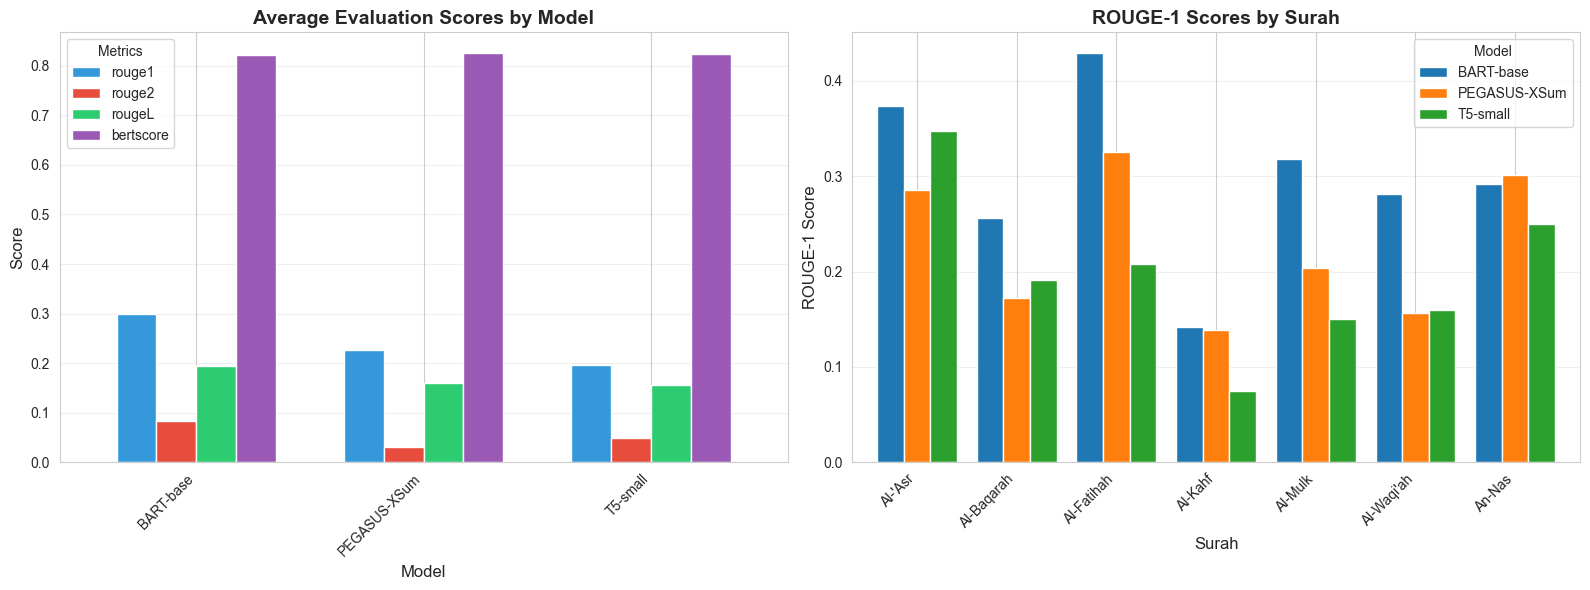

✓ Visualization saved as 'model_comparison.png'


In [35]:
# Create comparison visualization
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Plot 1: Average scores (ROUGE + BERTScore)
avg_scores.plot(kind='bar', ax=axes[0], width=0.7, color=['#3498db', '#e74c3c', '#2ecc71', '#9b59b6'])
axes[0].set_title('Average Evaluation Scores by Model', fontsize=14, fontweight='bold')
axes[0].set_xlabel('Model', fontsize=12)
axes[0].set_ylabel('Score', fontsize=12)
axes[0].legend(title='Metrics', fontsize=10)
axes[0].grid(axis='y', alpha=0.3)
axes[0].set_xticklabels(axes[0].get_xticklabels(), rotation=45, ha='right')

# Plot 2: ROUGE-1 scores by Surah
pivot_data = results_df.pivot(index='surah', columns='model', values='rouge1')
pivot_data.plot(kind='bar', ax=axes[1], width=0.8)
axes[1].set_title('ROUGE-1 Scores by Surah', fontsize=14, fontweight='bold')
axes[1].set_xlabel('Surah', fontsize=12)
axes[1].set_ylabel('ROUGE-1 Score', fontsize=12)
axes[1].legend(title='Model', fontsize=10)
axes[1].grid(axis='y', alpha=0.3)
axes[1].set_xticklabels(axes[1].get_xticklabels(), rotation=45, ha='right')

plt.tight_layout()
plt.savefig('model_comparison.png', dpi=300, bbox_inches='tight')
plt.show()

print("✓ Visualization saved as 'model_comparison.png'")

## 11. COMPARISON 2: Custom Test Samples

**Requirement:** Test and compare models using your own provided test samples

In [10]:
# Custom test samples
custom_test_samples = [
    {
        "surah_number": 36,
        "surah_name": "Ya-Sin",
        "description": "Heart of the Quran - discusses resurrection and divine signs"
    },
    {
        "surah_number": 55,
        "surah_name": "Ar-Rahman",
        "description": "Describes Allah's blessings and asks 'which favors will you deny?'"
    },
    {
        "surah_number": 67,
        "surah_name": "Al-Mulk",
        "description": "About Allah's sovereignty and the purpose of life"
    }
]

print("="*80)
print("COMPARISON 2: CUSTOM TEST SAMPLES")
print("="*80)

custom_results = []

for sample in custom_test_samples:
    surah_num = sample["surah_number"]
    surah_name = sample["surah_name"]
    
    print(f"\n{'='*60}")
    print(f"Testing: {surah_name}")
    print(f"Description: {sample['description']}")
    print(f"{'='*60}")
    
    # Load data
    translations = load_surah_translations(surah_num)
    emotions = detect_emotions_from_translations(translations)
    emotions_str = ", ".join(emotions)
    
    # Prepare input
    merged_text = ""
    for name, text in translations.items():
        merged_text += f"{text[:300]} "
    
    input_text = f"Summarize conveying {emotions_str}: {merged_text}"
    
    # Generate summaries from all 3 models
    print(f"\nDetected Emotions: {emotions_str}\n")
    
    print("1. T5-small:")
    summary_t5 = generate_summary_t5(input_text)
    print(f"   {summary_t5}")
    
    print("\n2. BART-base:")
    summary_bart = generate_summary_bart(input_text)
    print(f"   {summary_bart}")
    
    print("\n3. PEGASUS-XSum:")
    summary_pegasus = generate_summary_pegasus(input_text)
    print(f"   {summary_pegasus}")
    
    custom_results.append({
        "surah": surah_name,
        "emotions": emotions_str,
        "t5": summary_t5,
        "bart": summary_bart,
        "pegasus": summary_pegasus
    })

# Create comparison DataFrame
custom_df = pd.DataFrame(custom_results)
print("\n" + "="*100)
print("CUSTOM TEST RESULTS SUMMARY")
print("="*100)
print(custom_df[['surah', 'emotions']].to_string(index=False))

COMPARISON 2: CUSTOM TEST SAMPLES

Testing: Ya-Sin
Description: Heart of the Quran - discusses resurrection and divine signs

Detected Emotions: contemplation, warning and admonition

1. T5-small:
   a revelation of the Exalted in Might, the Merciful, that you may warn a folk whose fathers were not warned, so they are unaware. thou mayest admonish a people, whose fathers had received no admonition, and therefore remain heedless (of t Ya Sin).

2. BART-base:
   Summarize conveying contemplation, warning and admonition: Yā, Seen.1 By the wise1 Qur’ān, Indeed you, [O Muḥammad], are from among the messengers, On a straight path. [This is] a revelation of the Exalted in Might, the Merciful, That you may warn a people whose forefathers were not warned, so they are unaware. Already the word [i.e., decree] has come into  Ya Sin. By the Qur'an, full of Wisdom,- Thou art indeed one of the messes, Of those sent On a Straight Way. It is a Revelation sent down by (Him), the Exemplin Might,

3. PEGA

## 12. Gradio UI

**Requirement:** Add UI for the application

In [36]:
def gradio_summarize(surah_name, model_choice):
    """Generate summary through Gradio interface."""
    try:
        surah_num = surah_name_to_number.get(surah_name)
        if not surah_num:
            return "Error: Surah not found."
        
        # Load data
        translations = load_surah_translations(surah_num)
        emotions = detect_emotions_from_translations(translations)
        emotions_str = ", ".join(emotions)
        
        # Prepare input
        merged_text = ""
        for name, text in translations.items():
            merged_text += f"{text[:500]} "
        
        input_text = (
            f"Summarize this Quranic chapter conveying {emotions_str}. "
            f"Text: {merged_text}"
        )
        
        # Select model and generate
        if model_choice == "T5-small":
            summary = generate_summary_t5(input_text)
        elif model_choice == "BART-base":
            summary = generate_summary_bart(input_text)
        else:
            summary = generate_summary_pegasus(input_text)
        
        output = f"**Surah:** {surah_name} (#{surah_num})\n"
        output += f"**Model:** {model_choice}\n"
        output += f"**Detected Emotions:** {emotions_str}\n\n"
        output += f"**Summary:**\n{summary}"
        
        return output
    except Exception as e:
        return f"Error: {str(e)}"


# Create Gradio interface (GREEN THEME)
with gr.Blocks(
    title="Surah Summarizer",
    theme=gr.themes.Soft(primary_hue="green")
) as demo:

    gr.Markdown(
        """
        # 🕌 Quranic Surah Summarizer
        
        ## CMPE 258 Homework 2 - Multi-Model Comparison
        
        Compare different pre-trained models for emotion-aware summarization of Quranic Surahs.
        """
    )
    
    with gr.Row():
        with gr.Column():
            surah_input = gr.Dropdown(
                choices=SURAH_NAMES,
                label="Select Surah",
                value="Al-Fatihah"
            )
            model_input = gr.Radio(
                choices=["T5-small", "BART-base", "PEGASUS-XSum"],
                label="Select Model",
                value="T5-small"
            )
            submit_btn = gr.Button("Generate Summary", variant="primary")
        
        with gr.Column():
            output_text = gr.Textbox(
                label="Summary",
                lines=15,
                placeholder="Summary will appear here..."
            )
    
    submit_btn.click(
        fn=gradio_summarize,
        inputs=[surah_input, model_input],
        outputs=output_text
    )
    
    gr.Markdown(
        """
        ---
        **Features:**
        - 6 English translations analyzed per Surah
        - Emotion detection across translations
        - Three state-of-the-art summarization models
        - ROUGE + BERTScore evaluation metrics
        """
    )

print("\n🚀 Launching Gradio UI...")
demo.launch(share=True, show_error=True)



🚀 Launching Gradio UI...
Running on local URL:  http://127.0.0.1:7862


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


Running on public URL: https://93f92465a26cb5b617.gradio.live

This share link expires in 72 hours. For free permanent hosting and GPU upgrades, run `gradio deploy` from Terminal to deploy to Spaces (https://huggingface.co/spaces)
